#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
# from src.running import train_step1, eval_step1

In [14]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
def train_step1(model, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())

            loss = class_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [6]:
def eval_step1(model, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())

            loss = class_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                feat_numpy = feat_output.cpu().detach()
                action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

In [7]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [10]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [15]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
elif st == 'word2vec-v1':
    fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
elif st == 'word2vec-v2':
    fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'
elif st == 'attr':
    fpath = './data/PAMAP2_Dataset/attribute_ft.npy'
    
feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [16]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


seen: 100%|██████████| 131/131 [00:01<00:00, 77.25batch/s, loss=0.52]


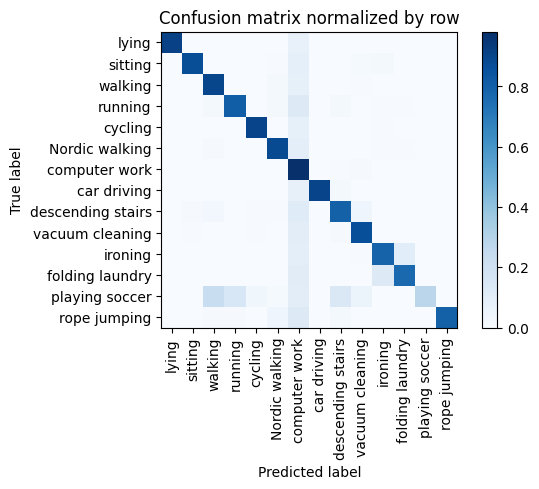

Training Epoch:  10%|█         | 1/10 [00:13<02:01, 13.55s/it]

Overall accuracy: 0.862



seen: 100%|██████████| 131/131 [00:01<00:00, 83.99batch/s, loss=0.627]


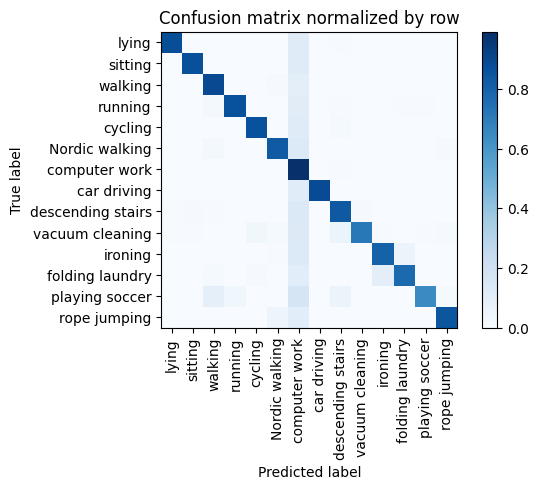

Training Epoch:  20%|██        | 2/10 [00:26<01:45, 13.14s/it]

Overall accuracy: 0.855



seen: 100%|██████████| 131/131 [00:02<00:00, 56.47batch/s, loss=0.255]


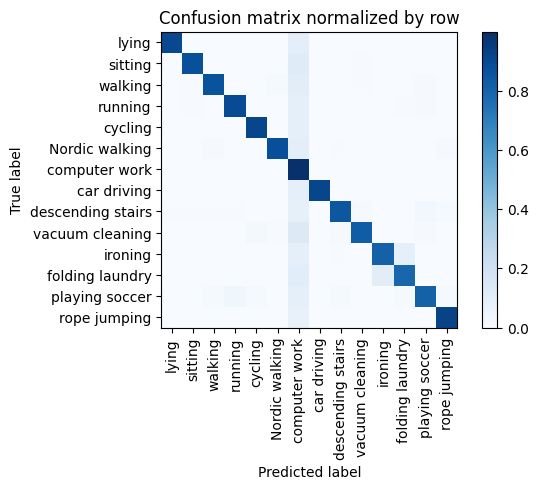

Training Epoch:  30%|███       | 3/10 [00:43<01:43, 14.82s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 131/131 [00:01<00:00, 71.58batch/s, loss=0.589]


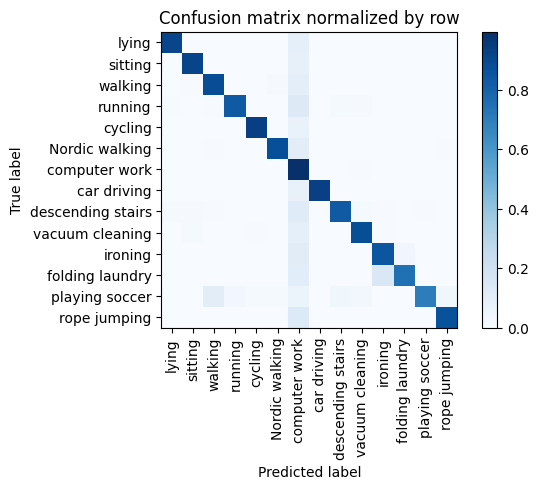

Training Epoch:  40%|████      | 4/10 [00:58<01:29, 14.85s/it]

Overall accuracy: 0.889



seen: 100%|██████████| 131/131 [00:02<00:00, 61.01batch/s, loss=0.186]


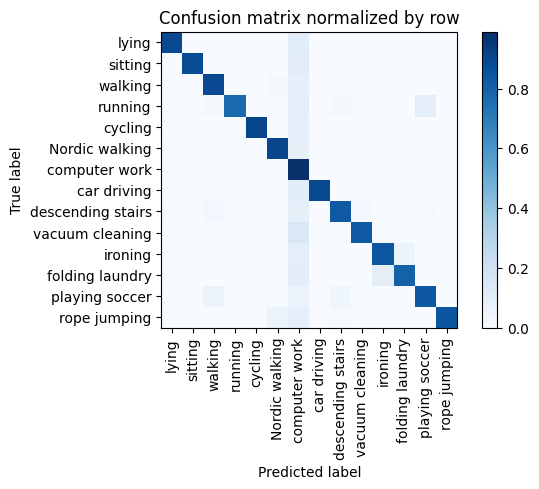

Training Epoch:  50%|█████     | 5/10 [01:14<01:16, 15.39s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 131/131 [00:01<00:00, 75.33batch/s, loss=0.31]


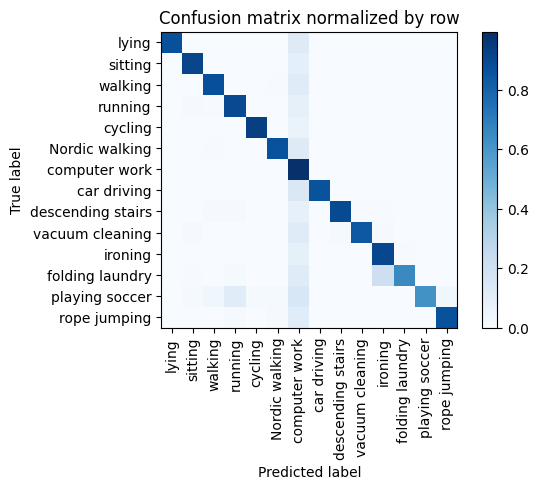

Training Epoch:  60%|██████    | 6/10 [01:28<00:59, 14.92s/it]

Overall accuracy: 0.884



seen: 100%|██████████| 131/131 [00:02<00:00, 61.30batch/s, loss=0.516]


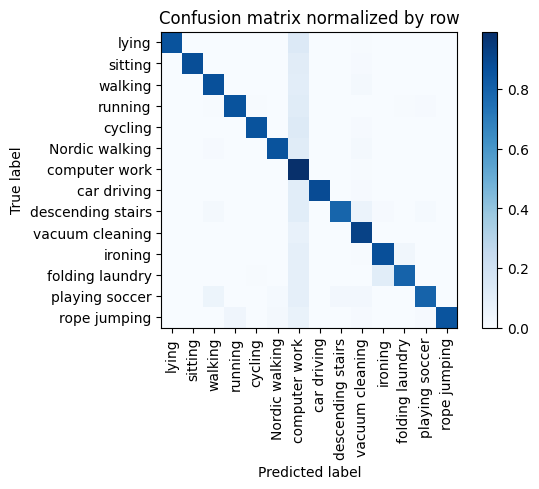

Training Epoch:  70%|███████   | 7/10 [01:42<00:43, 14.66s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 131/131 [00:01<00:00, 75.36batch/s, loss=0.214]


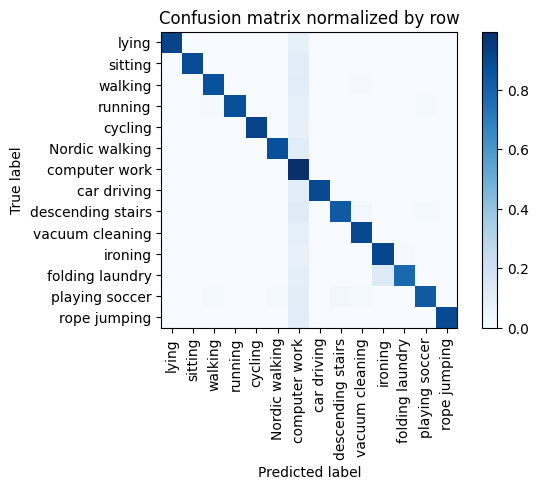

Training Epoch:  80%|████████  | 8/10 [01:56<00:28, 14.34s/it]

Overall accuracy: 0.898



seen: 100%|██████████| 131/131 [00:01<00:00, 75.90batch/s, loss=0.206]


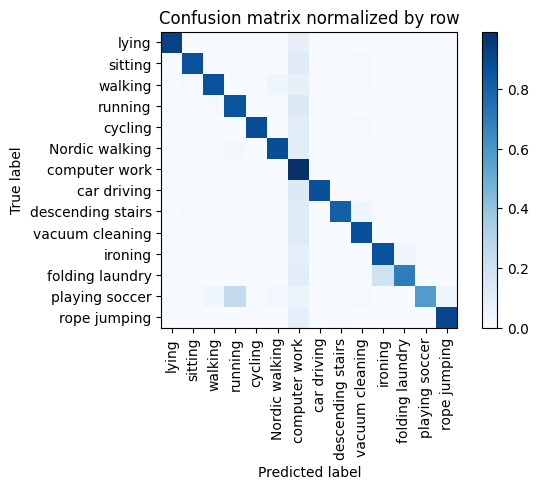

Training Epoch:  90%|█████████ | 9/10 [02:09<00:14, 14.10s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 131/131 [00:01<00:00, 75.35batch/s, loss=0.254]


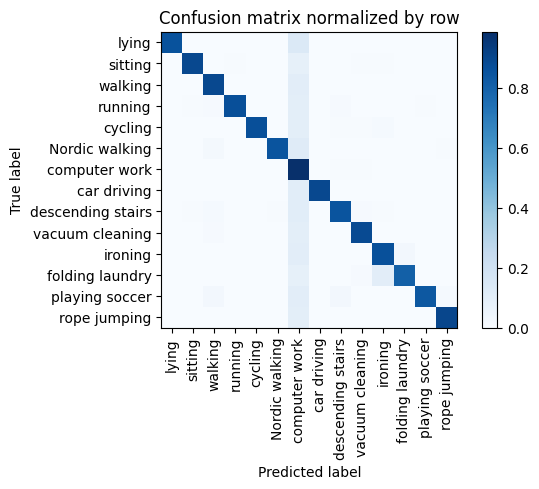

Overall accuracy: 0.886



unseen: 100%|██████████| 141/141 [00:01<00:00, 95.72batch/s, loss=13.5] 


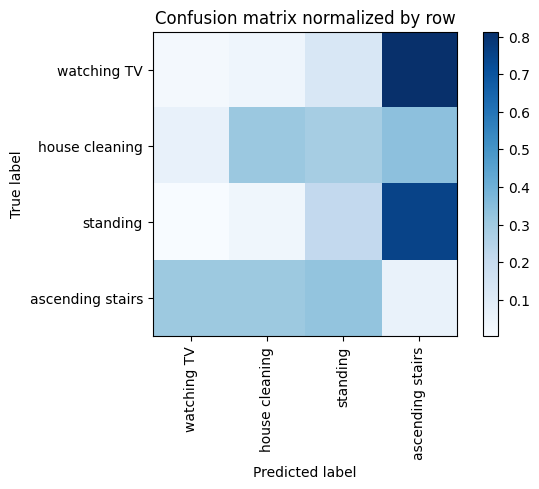

Overall accuracy: 0.187

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.574      0.310      0.403      0.331       1487|	 ascending stairs: 0.341,	standing: 0.286,	
        standing       0.282      0.214      0.243      0.325       1460|	 ascending stairs: 0.751,	house cleaning: 0.033,	
ascending stairs       0.024      0.060      0.034      0.194        872|	 standing: 0.326,	house cleaning: 0.307,	watching TV: 0.307,	
     watching TV       0.037      0.021      0.027      0.149        668|	 ascending stairs: 0.813,	standing: 0.127,	house cleaning: 0.039,	

----------------------------------------------------------------------------------------------------
     avg / total       0.292      0.187      0.223        1.0       4487|	      

{'total_accuracy': 0.18698462224203255, 'precision': 0.2291736902455037, 'recall': 0.1510774790852365, 'f1': 0.17659847821297944}
================ Fold-1 ================
Unseen Cl

seen: 100%|██████████| 132/132 [00:01<00:00, 72.15batch/s, loss=0.338]


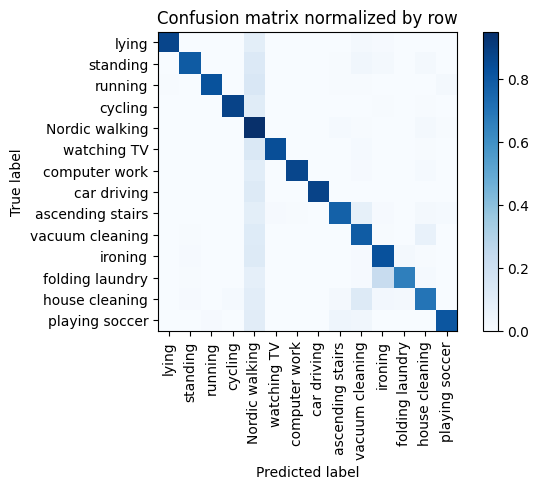

Training Epoch:  10%|█         | 1/10 [00:14<02:08, 14.33s/it]

Overall accuracy: 0.826



seen: 100%|██████████| 132/132 [00:01<00:00, 71.53batch/s, loss=0.141]


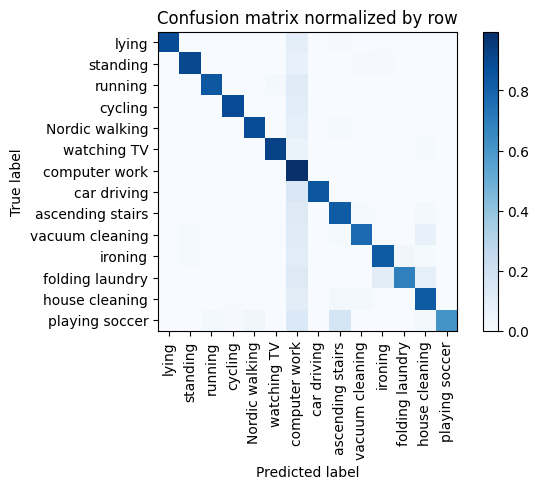

Training Epoch:  20%|██        | 2/10 [00:28<01:55, 14.45s/it]

Overall accuracy: 0.863



seen: 100%|██████████| 132/132 [00:01<00:00, 76.61batch/s, loss=0.0295]


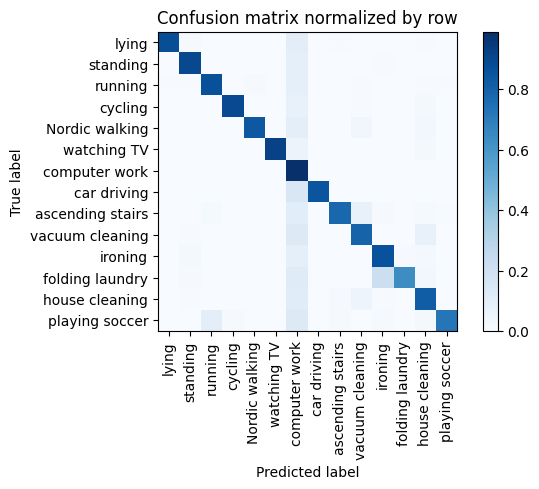

Training Epoch:  30%|███       | 3/10 [00:42<01:38, 14.10s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 132/132 [00:01<00:00, 74.13batch/s, loss=0.0736]


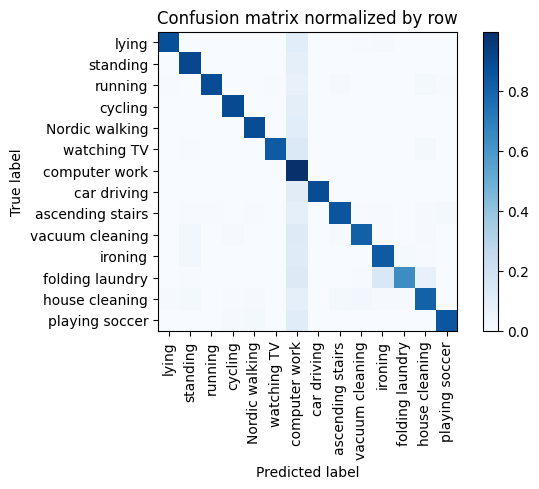

Training Epoch:  40%|████      | 4/10 [00:56<01:23, 13.95s/it]

Overall accuracy: 0.870



seen: 100%|██████████| 132/132 [00:01<00:00, 75.01batch/s, loss=0.543]


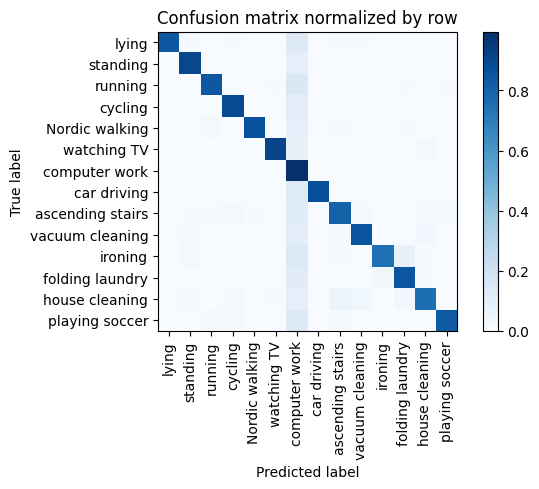

Training Epoch:  50%|█████     | 5/10 [01:10<01:10, 14.16s/it]

Overall accuracy: 0.863



seen: 100%|██████████| 132/132 [00:01<00:00, 66.11batch/s, loss=0.383]


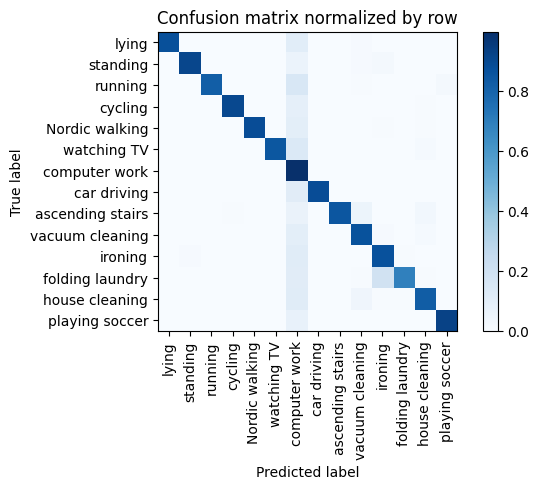

Training Epoch:  60%|██████    | 6/10 [01:24<00:56, 14.05s/it]

Overall accuracy: 0.883



seen: 100%|██████████| 132/132 [00:01<00:00, 74.55batch/s, loss=0.496]


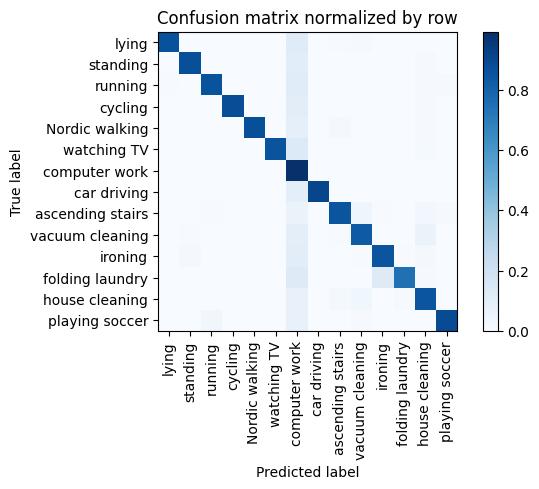

Training Epoch:  70%|███████   | 7/10 [01:38<00:41, 13.95s/it]

Overall accuracy: 0.876



seen: 100%|██████████| 132/132 [00:01<00:00, 73.49batch/s, loss=0.308]


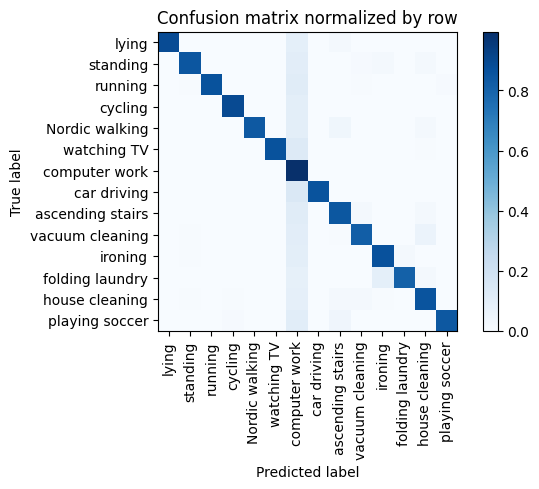

Training Epoch:  80%|████████  | 8/10 [01:52<00:27, 13.92s/it]

Overall accuracy: 0.877



seen: 100%|██████████| 132/132 [00:01<00:00, 76.54batch/s, loss=0.00549]


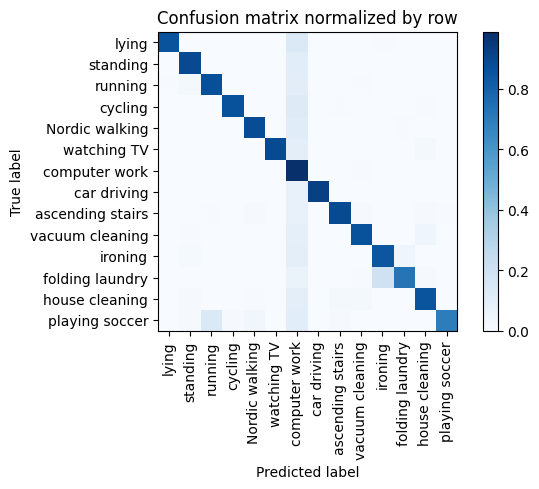

Training Epoch:  90%|█████████ | 9/10 [02:06<00:13, 13.88s/it]

Overall accuracy: 0.876



seen: 100%|██████████| 132/132 [00:01<00:00, 70.93batch/s, loss=0.167]


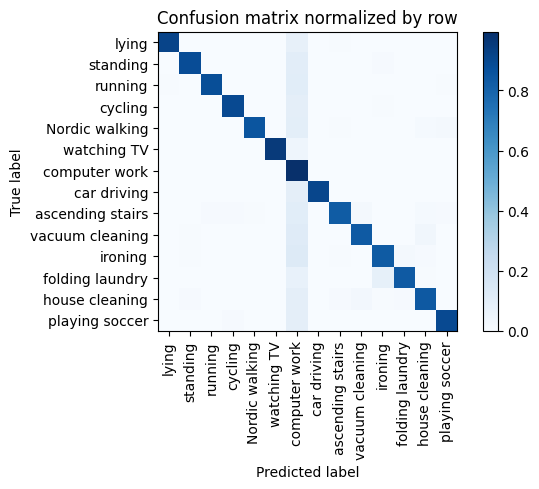

Overall accuracy: 0.886



unseen: 100%|██████████| 140/140 [00:01<00:00, 99.66batch/s, loss=22.6] 


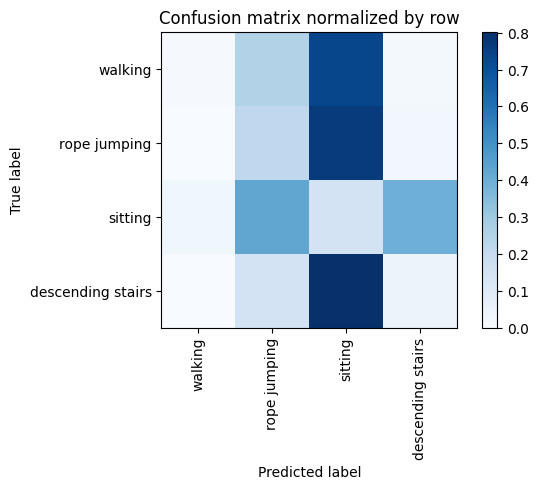

Overall accuracy: 0.076

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.207      0.006      0.012      0.421       1873|	 sitting: 0.730,	rope jumping: 0.248,	descending stairs: 0.015,	
          sitting       0.086      0.145      0.108      0.328       1461|	 rope jumping: 0.429,	descending stairs: 0.396,	
descending stairs       0.055      0.048      0.051      0.169        754|	 sitting: 0.802,	rope jumping: 0.147,	
     rope jumping       0.061      0.214      0.095      0.082        365|	 sitting: 0.767,	descending stairs: 0.019,	

----------------------------------------------------------------------------------------------------
      avg / total       0.130      0.076      0.057 0.9999999999999999       4453|	      

{'total_accuracy': 0.07590388502133394, 'precision': 0.10231512300917425, 'recall': 0.10323922847534833, 'f1': 0.06663014282604711}
================ Fold-2 ================
Unseen Classes : ['

seen: 100%|██████████| 122/122 [00:01<00:00, 74.56batch/s, loss=0.308]


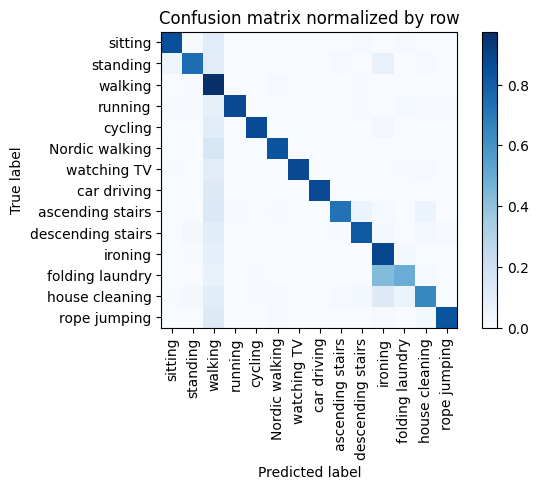

Training Epoch:  10%|█         | 1/10 [00:13<01:57, 13.01s/it]

Overall accuracy: 0.818



seen: 100%|██████████| 122/122 [00:01<00:00, 72.11batch/s, loss=0.529]


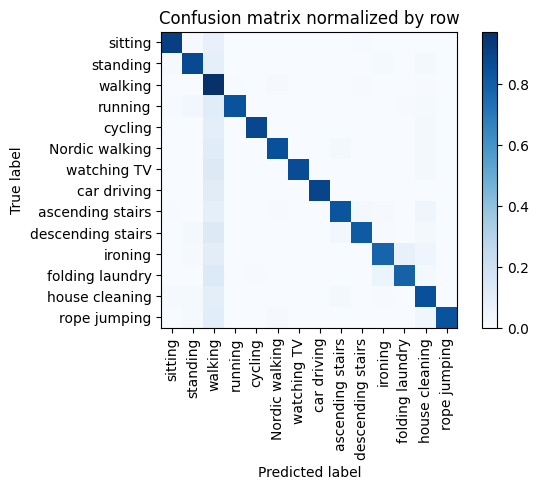

Training Epoch:  20%|██        | 2/10 [00:25<01:43, 12.88s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 122/122 [00:01<00:00, 68.14batch/s, loss=0.382]


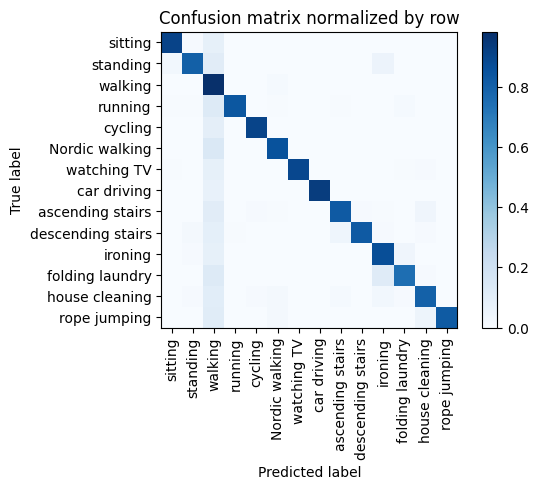

Training Epoch:  30%|███       | 3/10 [00:39<01:34, 13.46s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 122/122 [00:02<00:00, 56.35batch/s, loss=0.675]


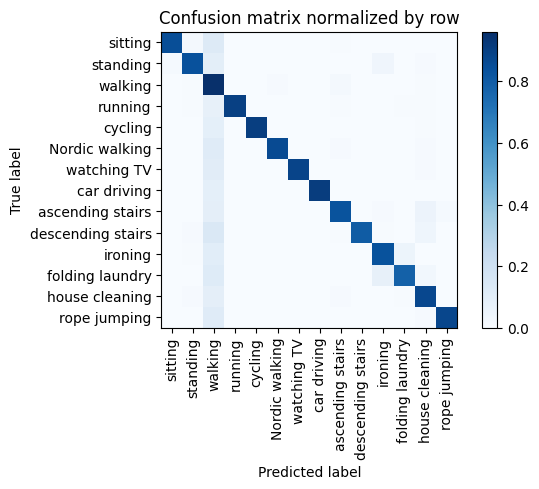

Training Epoch:  40%|████      | 4/10 [00:54<01:22, 13.77s/it]

Overall accuracy: 0.868



seen: 100%|██████████| 122/122 [00:01<00:00, 65.60batch/s, loss=0.423]


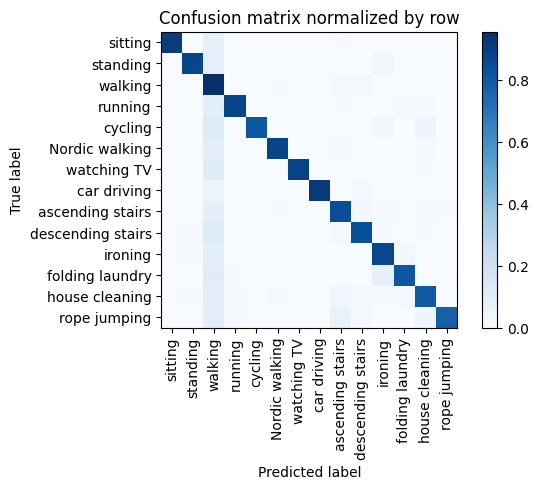

Training Epoch:  50%|█████     | 5/10 [01:08<01:09, 13.97s/it]

Overall accuracy: 0.867



seen: 100%|██████████| 122/122 [00:01<00:00, 70.94batch/s, loss=0.295]


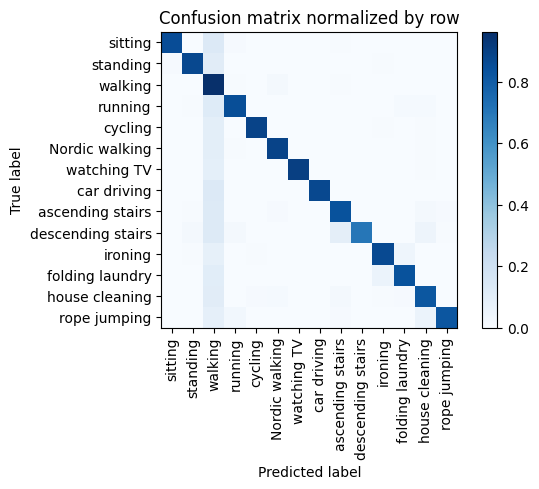

Training Epoch:  60%|██████    | 6/10 [01:21<00:55, 13.76s/it]

Overall accuracy: 0.866



seen: 100%|██████████| 122/122 [00:01<00:00, 72.51batch/s, loss=0.0183]


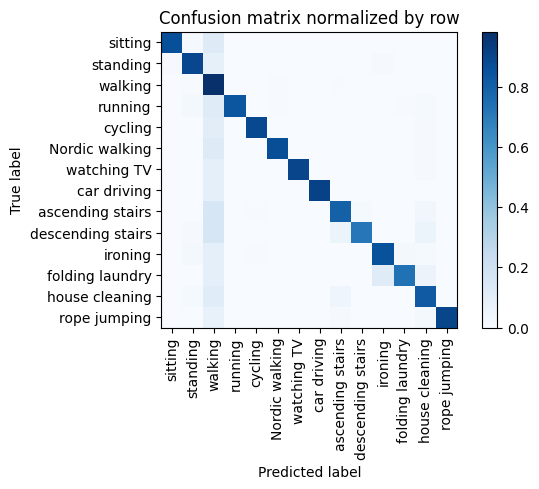

Training Epoch:  70%|███████   | 7/10 [01:34<00:40, 13.54s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 122/122 [00:01<00:00, 71.76batch/s, loss=0.00332]


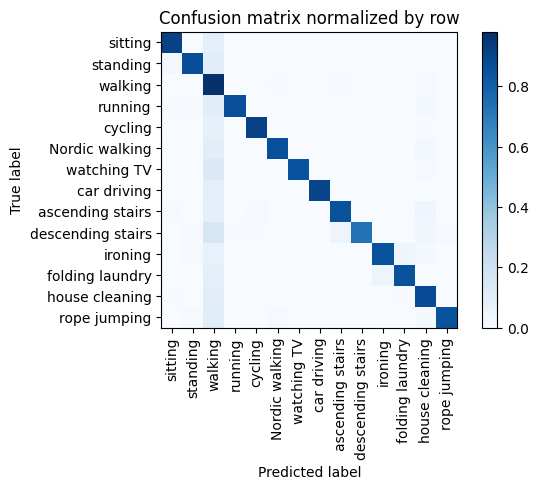

Training Epoch:  80%|████████  | 8/10 [01:47<00:26, 13.35s/it]

Overall accuracy: 0.879



seen: 100%|██████████| 122/122 [00:01<00:00, 71.14batch/s, loss=0.44]


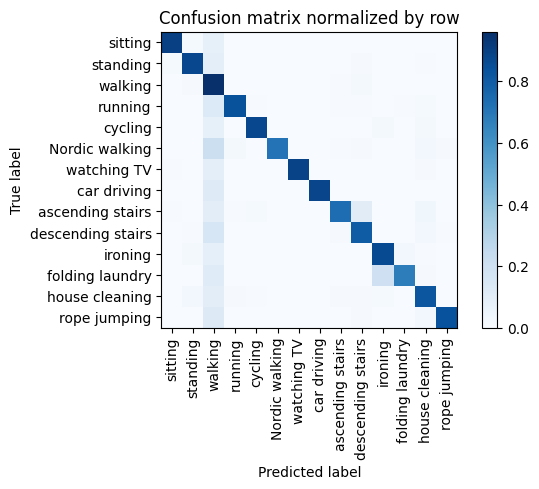

Training Epoch:  90%|█████████ | 9/10 [02:01<00:13, 13.45s/it]

Overall accuracy: 0.841



seen: 100%|██████████| 122/122 [00:01<00:00, 70.35batch/s, loss=0.379]


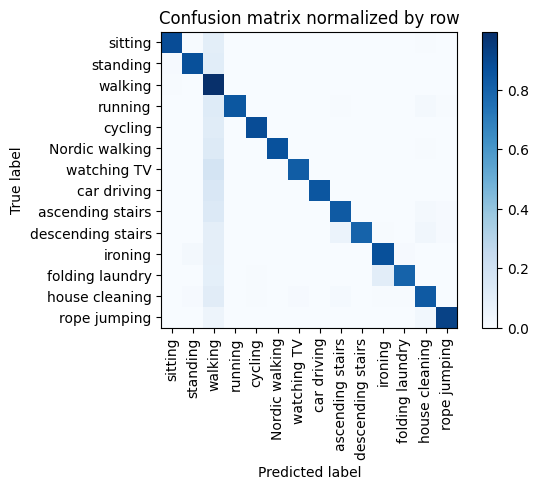

Overall accuracy: 0.874



unseen: 100%|██████████| 179/179 [00:02<00:00, 87.57batch/s, loss=11.2]


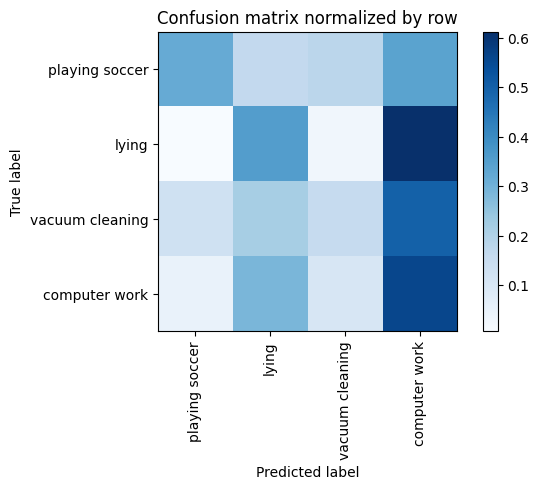

Overall accuracy: 0.392

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.445      0.558      0.495      0.433       2470|	 lying: 0.288,	vacuum cleaning: 0.105,	
          lying       0.328      0.353      0.340      0.259       1478|	 computer work: 0.612,	vacuum cleaning: 0.028,	
vacuum cleaning       0.369      0.156      0.219      0.242       1377|	 computer work: 0.497,	lying: 0.216,	
 playing soccer       0.276      0.317      0.295      0.066        375|	 computer work: 0.339,	vacuum cleaning: 0.179,	

----------------------------------------------------------------------------------------------------
    avg / total       0.385      0.392      0.375        1.0       5700|	      

{'total_accuracy': 0.3919298245614035, 'precision': 0.354644915701726, 'recall': 0.34613614294934686, 'f1': 0.33751665490413363}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']


seen: 100%|██████████| 139/139 [00:02<00:00, 67.71batch/s, loss=0.401]


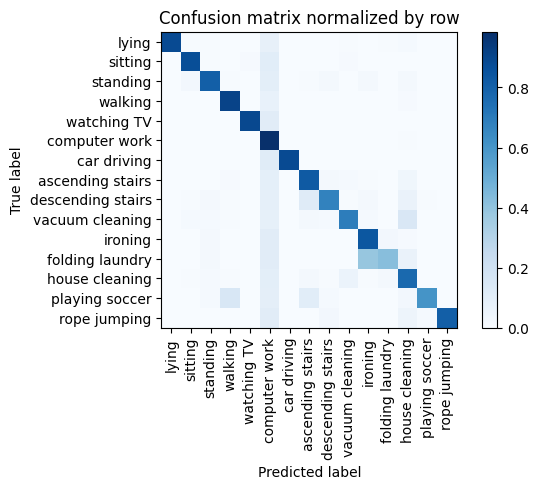

Training Epoch:  10%|█         | 1/10 [00:15<02:22, 15.84s/it]

Overall accuracy: 0.824



seen: 100%|██████████| 139/139 [00:02<00:00, 68.12batch/s, loss=0.323]


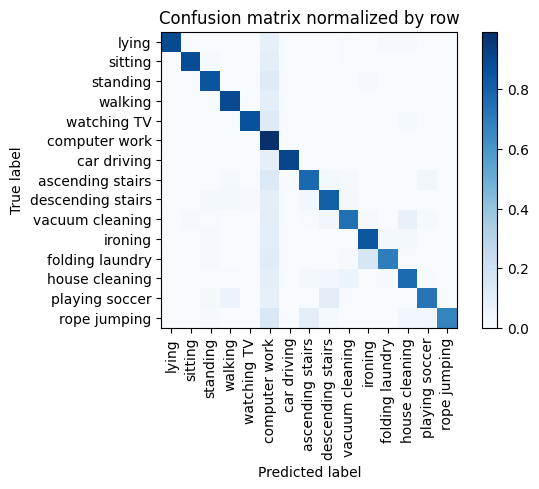

Training Epoch:  20%|██        | 2/10 [00:31<02:03, 15.47s/it]

Overall accuracy: 0.850



seen: 100%|██████████| 139/139 [00:01<00:00, 71.76batch/s, loss=0.767]


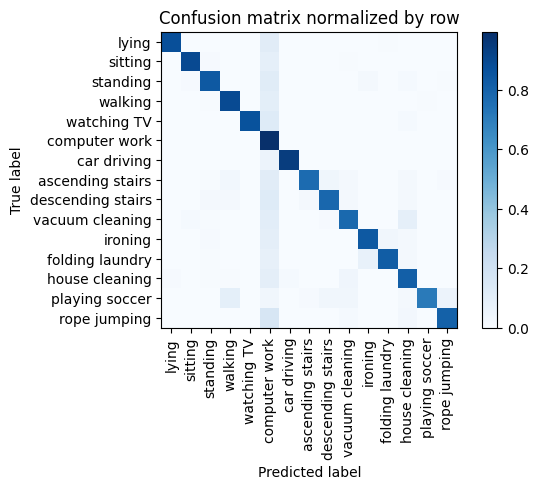

Training Epoch:  30%|███       | 3/10 [00:46<01:49, 15.57s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 139/139 [00:02<00:00, 69.18batch/s, loss=0.825]


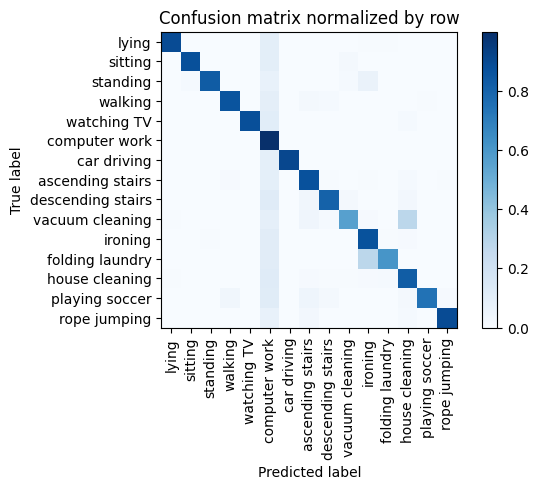

Training Epoch:  40%|████      | 4/10 [01:02<01:34, 15.82s/it]

Overall accuracy: 0.843



seen: 100%|██████████| 139/139 [00:02<00:00, 62.46batch/s, loss=0.577]


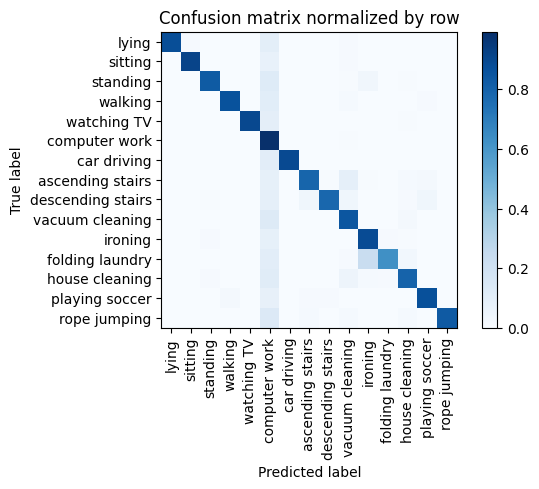

Training Epoch:  50%|█████     | 5/10 [01:19<01:19, 16.00s/it]

Overall accuracy: 0.863



seen: 100%|██████████| 139/139 [00:02<00:00, 58.34batch/s, loss=0.394]


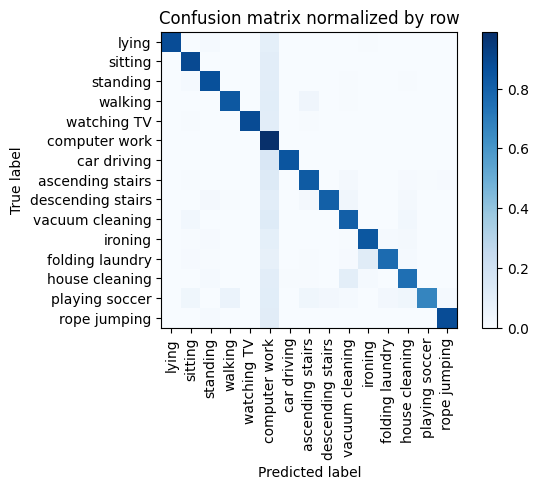

Training Epoch:  60%|██████    | 6/10 [01:35<01:04, 16.10s/it]

Overall accuracy: 0.855



seen: 100%|██████████| 139/139 [00:02<00:00, 68.95batch/s, loss=0.499]


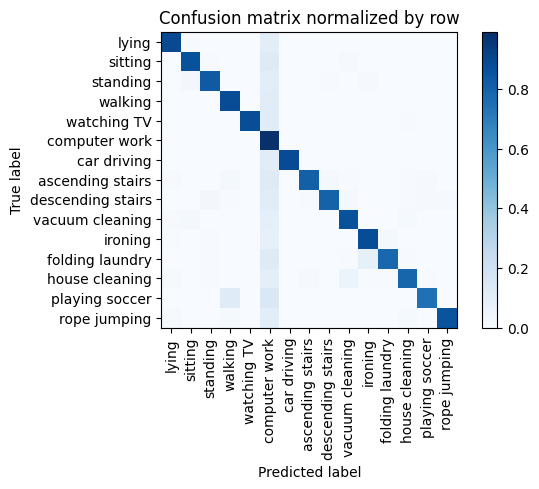

Training Epoch:  70%|███████   | 7/10 [01:51<00:48, 16.00s/it]

Overall accuracy: 0.868



seen: 100%|██████████| 139/139 [00:02<00:00, 64.12batch/s, loss=0.877]


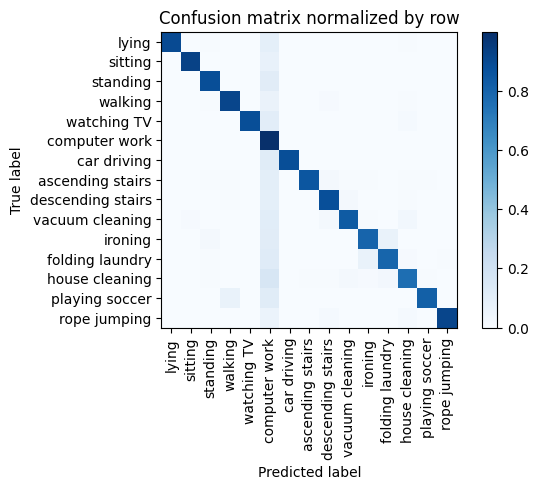

Training Epoch:  80%|████████  | 8/10 [02:07<00:32, 16.02s/it]

Overall accuracy: 0.878



seen: 100%|██████████| 139/139 [00:01<00:00, 70.45batch/s, loss=0.00467]


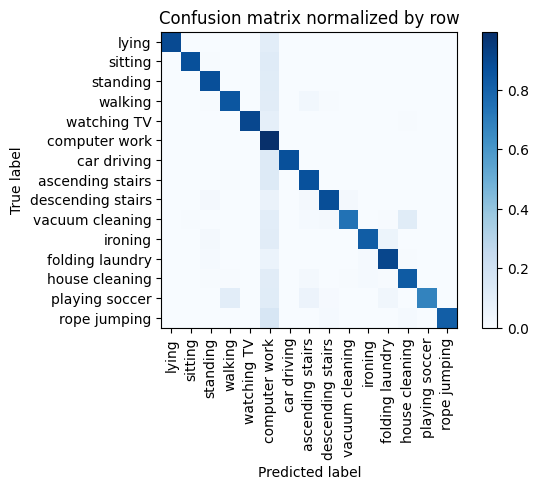

Training Epoch:  90%|█████████ | 9/10 [02:22<00:15, 15.66s/it]

Overall accuracy: 0.869



seen: 100%|██████████| 139/139 [00:01<00:00, 75.91batch/s, loss=0.159]


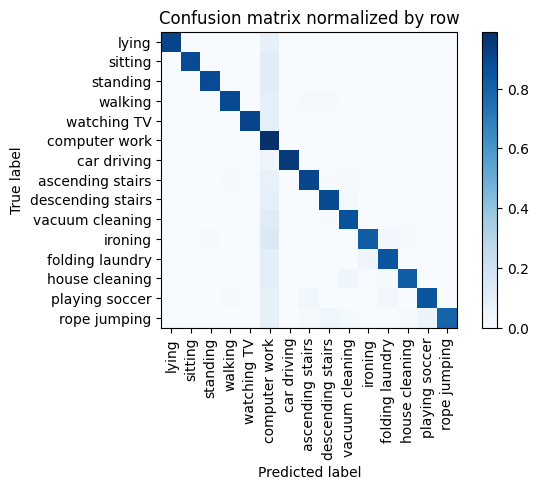

Overall accuracy: 0.887



unseen: 100%|██████████| 110/110 [00:01<00:00, 86.44batch/s, loss=28.2]


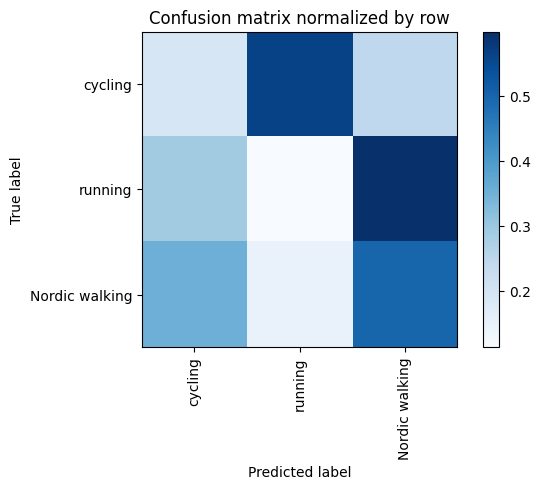

Overall accuracy: 0.304

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.490      0.500      0.495      0.420       1477|	 cycling: 0.353,	running: 0.147,	
       cycling       0.249      0.192      0.217      0.363       1278|	 running: 0.564,	Nordic walking: 0.243,	
       running       0.084      0.113      0.096      0.217        762|	 Nordic walking: 0.598,	cycling: 0.289,	

----------------------------------------------------------------------------------------------------
   avg / total       0.315      0.304      0.308        1.0       3517|	      

{'total_accuracy': 0.30423656525447823, 'precision': 0.27444589258533186, 'recall': 0.26833687708801435, 'f1': 0.2694656977736597}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


seen: 100%|██████████| 142/142 [00:01<00:00, 75.65batch/s, loss=0.507]


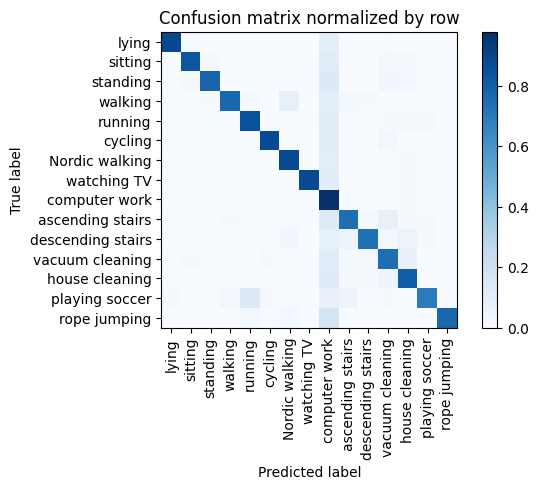

Training Epoch:  10%|█         | 1/10 [00:14<02:12, 14.77s/it]

Overall accuracy: 0.835



seen: 100%|██████████| 142/142 [00:02<00:00, 58.28batch/s, loss=0.366]


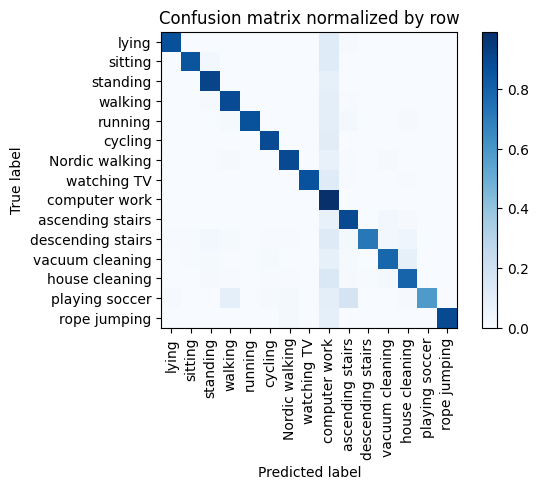

Training Epoch:  20%|██        | 2/10 [00:30<02:04, 15.58s/it]

Overall accuracy: 0.870



seen: 100%|██████████| 142/142 [00:02<00:00, 51.75batch/s, loss=0.248]


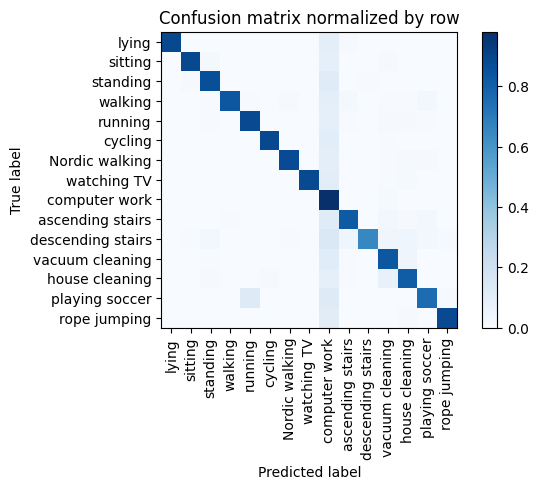

Training Epoch:  30%|███       | 3/10 [00:55<02:17, 19.61s/it]

Overall accuracy: 0.865



seen: 100%|██████████| 142/142 [00:02<00:00, 59.56batch/s, loss=0.433]


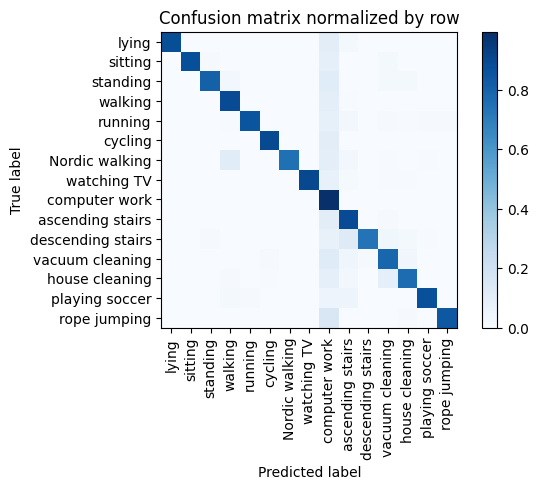

Training Epoch:  40%|████      | 4/10 [01:14<01:56, 19.40s/it]

Overall accuracy: 0.858



seen: 100%|██████████| 142/142 [00:05<00:00, 27.10batch/s, loss=0.0154]


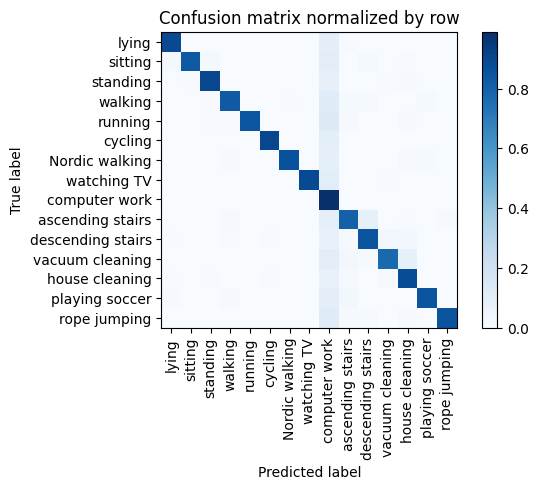

Training Epoch:  50%|█████     | 5/10 [01:40<01:49, 21.94s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 142/142 [00:02<00:00, 61.18batch/s, loss=0.23]


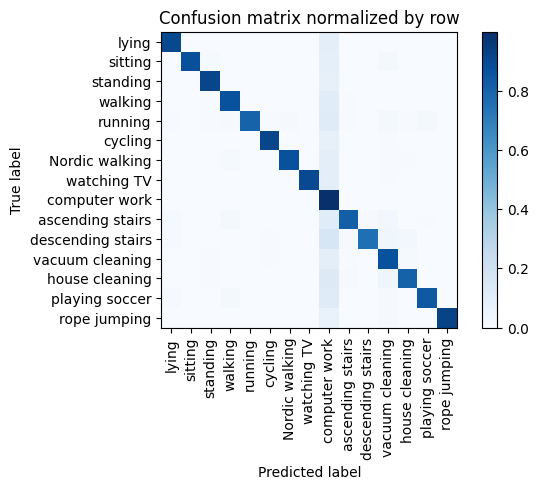

Training Epoch:  60%|██████    | 6/10 [02:04<01:29, 22.42s/it]

Overall accuracy: 0.885



seen: 100%|██████████| 142/142 [00:03<00:00, 45.20batch/s, loss=0.417]


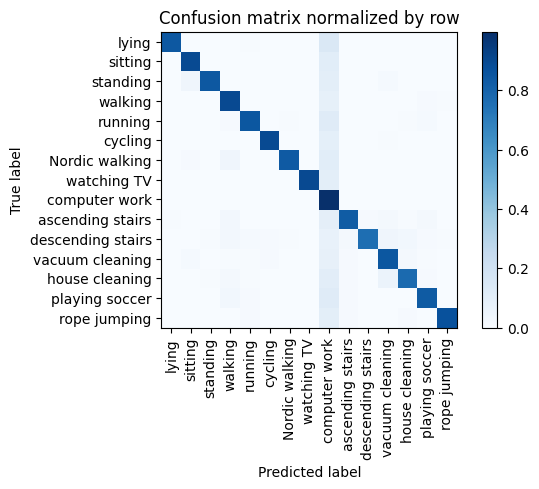

Training Epoch:  70%|███████   | 7/10 [02:28<01:08, 22.91s/it]

Overall accuracy: 0.870



seen: 100%|██████████| 142/142 [00:03<00:00, 36.56batch/s, loss=0.214]


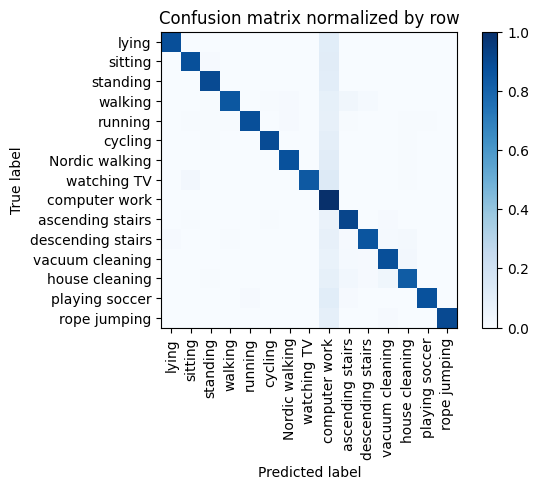

Training Epoch:  80%|████████  | 8/10 [02:59<00:51, 25.73s/it]

Overall accuracy: 0.891



seen: 100%|██████████| 142/142 [00:03<00:00, 44.00batch/s, loss=0.286]


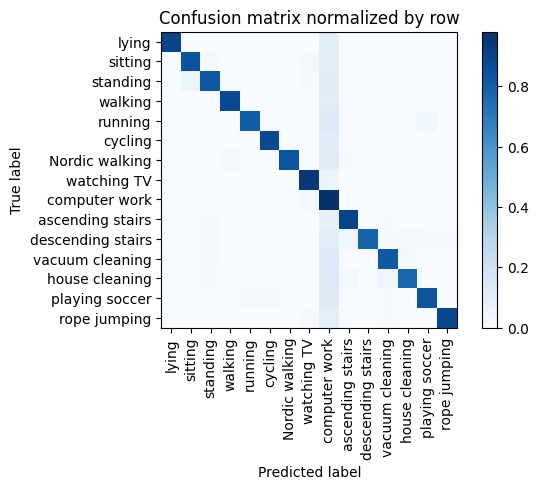

Training Epoch:  90%|█████████ | 9/10 [03:35<00:28, 28.87s/it]

Overall accuracy: 0.870



seen: 100%|██████████| 142/142 [00:03<00:00, 40.99batch/s, loss=0.423]


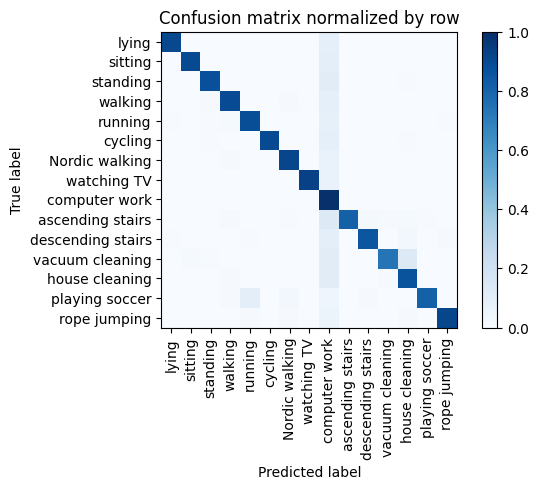

Overall accuracy: 0.890



unseen: 100%|██████████| 97/97 [00:01<00:00, 63.43batch/s, loss=14.1]


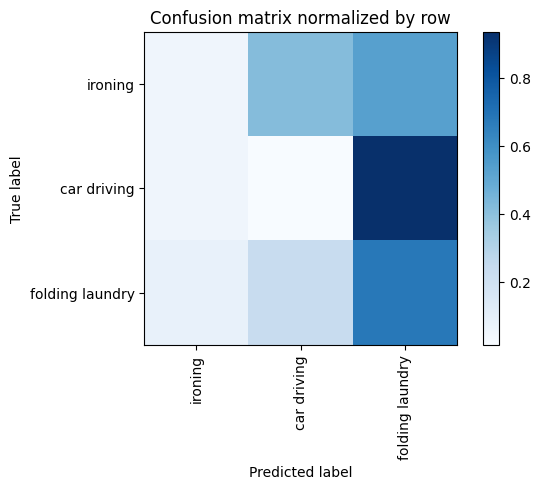

Overall accuracy: 0.206

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.527      0.052      0.095      0.605       1867|	 folding laundry: 0.531,	car driving: 0.416,	
folding laundry       0.276      0.679      0.392      0.254        783|	 car driving: 0.236,	ironing: 0.084,	
    car driving       0.006      0.014      0.009      0.141        435|	 folding laundry: 0.936,	ironing: 0.051,	

----------------------------------------------------------------------------------------------------
    avg / total       0.390      0.206      0.158        1.0       3085|	      

{'total_accuracy': 0.20615883306320906, 'precision': 0.2695283290894183, 'recall': 0.2485739296234959, 'f1': 0.16535480394635285}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.233043
precision         0.246022
recall            0.223473
f1                0.203113
dtype: float64

In [17]:
from tkinter import N


fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len, n_classes=len(seen_classes))
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'class': nn.CrossEntropyLoss(), 'feature': MSELoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step1(model, train_dl, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', )
        eval_metrics = eval_step1(model, eval_dl, loss_module, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='seen',  print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen')
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    